# Comparaison des prédictions des différentes lignées cellulaires et du modèle estimé par apprentissage de transfert sur certaines séquences de test

In [1]:
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import h5py
import cooler

In [3]:
import matplotlib.pyplot as plt

In [4]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_test/"
predfile = predpath + "preds.h5"

In [5]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [6]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [7]:
pred['preds'].shape

(6667, 99681, 5)

In [8]:
targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1m/seqs_cov/0.h5"

In [9]:
targets = h5py.File(targetfile, 'r')
targets

<HDF5 file "0.h5" (mode r)>

In [10]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]

In [11]:
test_targets.shape

(6667, 99681)

In [12]:
predf = h5py.File('pred_final.h5', 'r')
predf

<HDF5 file "pred_final.h5" (mode r)>

In [13]:
predf.keys()

<KeysViewHDF5 ['pred_final']>

In [14]:
predf['pred_final'].shape

(6667, 99681)

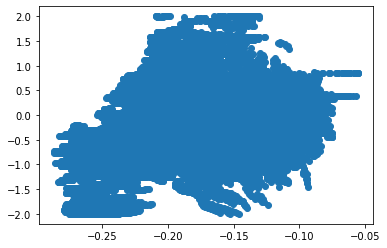

In [16]:
plt.scatter(predf['pred_final'][1,:], test_targets[1,:])
plt.show()

## Décalage entre les séquences

In [16]:
params_file = "/home/bureau/projects/def-bureau/basenji/manuscripts/akita/params.json"
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seq_length = params_model['seq_length']
target_length = params_model['target_length']
target_crop = params_model['target_crop']
hic_diags = 2
target_length_cropped = target_length - 2*target_crop
n = target_length_cropped - hic_diags
tlen = n * (n+1) // 2
tlen

99681

In [19]:
k = 16
decal = int(k*(n-(k-1)/2))
decal

7016

In [41]:
hic_targets = pd.read_csv('/home/bureau/projects/def-bureau/basenji/manuscripts/akita/data/targets.txt',sep='\t')
hic_targets

,index,identifier,file,clip,description
0,0,HFF,../../data/coolers/Krietenstein2019/HFF_hg38_4...,2,HFF
1,1,H1hESC,../../data/coolers/Krietenstein2019/H1hESC_hg3...,2,H1hESC
2,2,GM12878,../../data/coolers/Rao2014/GM12878_inSitu_MboI...,2,GM12878
3,3,IMR90,../../data/coolers/Rao2014/IMR90_inSitu_MboI_a...,2,IMR90
4,4,HCT116,../../data/coolers/Rao2017/Unsynchronized_all....,2,HCT116


## Examen de points de contact

In [39]:
# Ce n'est pas égal
display([test_targets[1,0],test_targets[0,decal]])
display([test_targets[2,0],test_targets[1,decal],test_targets[0,2*decal]])
display([test_targets[3,0],test_targets[2,decal],test_targets[1,2*decal],test_targets[0,3*decal]])

[0.3306, -0.4355]

[-0.2554, 0.219, 0.1333]

[0.273, 0.00873, 0.5083, -0.912]

## Trouver une valeur égale dans une autre séquence

In [28]:
tmp = list(abs(test_targets[0,]-test_targets[1,0])<0.0001)
tmp.index(True)

7362

In [29]:
[test_targets[1,0],test_targets[0,tmp.index(True)]]

[0.3306, 0.3306]

In [88]:
tmp = list(abs(test_targets[10,]-test_targets[13,4])<0.0001)
tmp.index(True)

ValueError: True is not in list

In [122]:
index_vec = []
for j in range(13):
    tmp = list(abs(test_targets[j,]-test_targets[13,0])<0.0001)
    index_vec.append(tmp.index(True))
index_vec

[60946,
 37,
 32649,
 8836,
 53352,
 55160,
 98784,
 56366,
 85320,
 31089,
 89826,
 65326,
 49028]

In [97]:
len(index_vec)

13

In [123]:
display(test_targets[13,0])
for j in range(len(index_vec)):
    display(test_targets[j,index_vec[j]])

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

0.2593

In [124]:
pred_orig = np.zeros((14,pred['preds'].shape[2]))
for j in range(len(index_vec)):
    pred_orig[j] = pred['preds'][j,index_vec[j],]
pred_orig[13] = pred['preds'][13,0,]
pred_orig

array([[-5.31250000e-01, -3.67187500e-01, -3.28857422e-01,
        -4.61669922e-01, -3.27880859e-01],
       [-3.03222656e-01, -2.23510742e-01, -1.79809570e-01,
        -2.44506836e-01, -1.74560547e-01],
       [-4.07470703e-01, -3.90136719e-01, -2.54394531e-01,
        -3.21289062e-01, -1.71020508e-01],
       [-1.58007812e+00, -1.23535156e+00, -1.07421875e+00,
        -1.59472656e+00, -9.33105469e-01],
       [-2.32543945e-01, -1.69311523e-01, -8.31298828e-02,
        -1.30004883e-01, -1.25244141e-01],
       [ 1.69677734e-01,  1.17675781e-01,  3.90625000e-02,
         1.17004395e-01,  2.24304199e-02],
       [-1.25976562e-01, -1.32568359e-01, -1.47949219e-01,
        -1.67846680e-01, -8.90502930e-02],
       [-5.15136719e-01, -3.85253906e-01, -2.98828125e-01,
        -4.17480469e-01, -3.34716797e-01],
       [-7.27539062e-02, -2.83813477e-02, -2.56805420e-02,
        -4.65698242e-02, -6.71386719e-02],
       [ 2.71728516e-01,  2.39257812e-01,  1.44897461e-01,
         2.40722656e-01

In [125]:
pred_transfer = []
for j in range(len(index_vec)):
    pred_transfer.append(predf['pred_final'][j,index_vec[j]])
pred_transfer.append(predf['pred_final'][13,0])
pred_transfer

[-0.13952295803924492,
 -0.14812967625707912,
 -0.2015016099624587,
 -0.23143619153790415,
 -0.14405091923694222,
 -0.12907389893676455,
 -0.1206972912324997,
 -0.14981437513337864,
 -0.10192116394771097,
 -0.13493473082793395,
 -0.11356417584029474,
 -0.17163006154802118,
 -0.16594476221264504,
 -0.08512952792961445]

In [126]:
pred_dat = pd.DataFrame(pred_orig,columns=hic_targets['identifier'])
pred_dat["Neuron"] = pred_transfer
pred_dat

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
0,-0.531250,-0.367188,-0.328857,-0.461670,-0.327881,-0.139523
1,-0.303223,-0.223511,-0.179810,-0.244507,-0.174561,-0.148130
2,-0.407471,-0.390137,-0.254395,-0.321289,-0.171021,-0.201502
3,-1.580078,-1.235352,-1.074219,-1.594727,-0.933105,-0.231436
4,-0.232544,-0.169312,-0.083130,-0.130005,-0.125244,-0.144051
5,0.169678,0.117676,0.039062,0.117004,0.022430,-0.129074
6,-0.125977,-0.132568,-0.147949,-0.167847,-0.089050,-0.120697
7,-0.515137,-0.385254,-0.298828,-0.417480,-0.334717,-0.149814
8,-0.072754,-0.028381,-0.025681,-0.046570,-0.067139,-0.101921
9,0.271729,0.239258,0.144897,0.240723,0.099060,-0.134935


In [127]:
# Biais
bias = pred_dat.mean() - test_targets[13,0]
bias

identifier
HFF       -0.499650
H1hESC    -0.435026
GM12878   -0.419574
IMR90     -0.469900
HCT116    -0.417199
Neuron    -0.404802
dtype: float64

In [128]:
# Biais estimé avec la médiane
bias_med = pred_dat.median() - test_targets[13,0]
bias_med

identifier
HFF       -0.438538
H1hESC    -0.410217
GM12878   -0.374817
IMR90     -0.408203
HCT116    -0.366425
Neuron    -0.401064
dtype: float64

In [129]:
var = pred_dat.var()
var

identifier
HFF        0.241677
H1hESC     0.159450
GM12878    0.101262
IMR90      0.227080
HCT116     0.074964
Neuron     0.001480
dtype: float64

In [130]:
# MSE
bias*bias + var

identifier
HFF        0.491327
H1hESC     0.348698
GM12878    0.277304
IMR90      0.447886
HCT116     0.249020
Neuron     0.165345
dtype: float64

In [131]:
# Corrélation
pred_dat.corr()

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
identifier,,,,,,
HFF,1.000000,0.994161,0.987516,0.992794,0.991483,0.642992
H1hESC,0.994161,1.000000,0.988879,0.988794,0.983588,0.621965
GM12878,0.987516,0.988879,1.000000,0.997703,0.988939,0.618510
IMR90,0.992794,0.988794,0.997703,1.000000,0.993052,0.635725
HCT116,0.991483,0.983588,0.988939,0.993052,1.000000,0.589957
Neuron,0.642992,0.621965,0.618510,0.635725,0.589957,1.000000


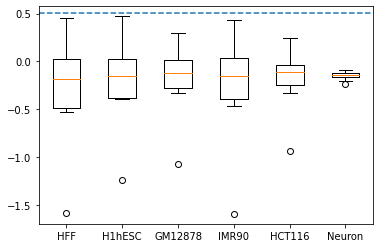

In [132]:
plt.boxplot(pred_dat,labels=pred_dat.columns)
plt.axhline(y=test_targets[13,12], ls='--')
plt.show()

In [133]:
# Test de Wilcoxon
from scipy import stats
stats.wilcoxon(pred_dat["Neuron"],pred_dat["HCT116"])

WilcoxonResult(statistic=45.0, pvalue=0.6377666989276032)

In [134]:
stats.wilcoxon(pred_dat["Neuron"],pred_dat["GM12878"])

WilcoxonResult(statistic=50.0, pvalue=0.8752911852109797)